# Intro
Our task was to find the best neighborhood in Pittsburgh and to do this, we created a data-driven metric designed to evaluate the “best neighborhood for a family.” We decided to calculate this metric based on a given neighborhood’s tree cover, the crime rate, and number of accessible parks. The component data that we used for this project came from the Western Pennsylvania Regional Data Center.

In [2]:
# IMPORTS
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import math

# Trees
This data was included in our metric with the idea that the more trees are in a neighborhood, the more inviting it would be especially for children. When we first found this dataset, we believed that it was a complete tree cover dataset for the city of Pittsburgh. After working with the data for a while, it became clear that it must only include entries for trees that are planted or maintained by the city or municipal government. This is because each tree entry was far too detailed to account for every tree in Frick Park for example. In addition, some neighborhoods appeared to have far more trees than were reported here. We realized, however, that this data was still valuable because if it’s comprised of trees maintained by the government, a higher number of trees indicates strong civic initiatives. In addition, most trees planted and maintained by local governments are located in highly urbanized areas, so this tree score can also help to bolster a region that may not have many parks, but still has a lot of maintained green space.

In [4]:
neighborhoods = gpd.read_file("https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/neighborhoods.geojson")
trees = gpd.read_file("https://data.wprdc.org/dataset/9ce31f01-1dfa-4a14-9969-a5c5507a4b40/resource/d876927a-d3da-44d1-82e1-24310cdb7baf/download/trees_img.geojson")

In [5]:
trees = trees.to_crs(neighborhoods.crs)

trees_with_neighborhoods = gpd.sjoin(trees, neighborhoods, how="inner", predicate="within")
tree_counts = trees_with_neighborhoods.groupby("hood").size().reset_index(name='tree_count')

neighborhoods_with_counts = neighborhoods.merge(tree_counts, on="hood", how="left")
neighborhoods_with_counts["tree_count"] = neighborhoods_with_counts["tree_count"].fillna(0).astype(int)

neighborhoods_with_counts['trees_per_area'] = neighborhoods_with_counts['tree_count'] / neighborhoods_with_counts['Shape__Area']
max_tree_count = neighborhoods_with_counts['trees_per_area'].max()
neighborhoods_with_counts['proportion'] = neighborhoods_with_counts['trees_per_area'] / max_tree_count

neighborhoods_with_counts = neighborhoods_with_counts.sort_values(by='proportion', ascending=False)
neighborhoods_with_counts.reset_index(drop=True, inplace=True)

trees_final = neighborhoods_with_counts[['hood', 'tree_count', 'proportion']]

<Axes: >

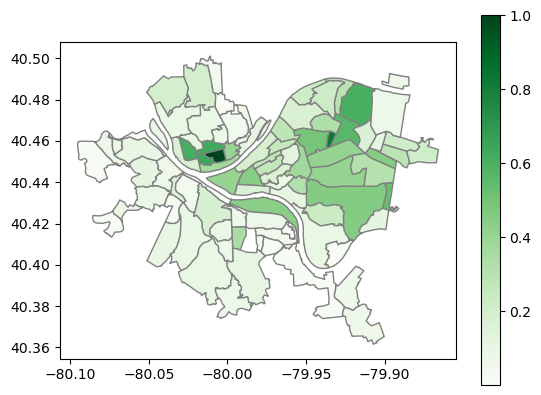

In [6]:
neighborhoods_with_counts.plot(column='proportion',cmap='Greens', edgecolor='gray', legend=True)

In [7]:
trees_final.head()

,hood,tree_count,proportion
0,Allegheny Center,867,1.000000
1,Friendship,362,0.821514
2,Allegheny West,386,0.642439
3,Central Northside,674,0.625490
4,Manchester,707,0.610570


# Crime
For our crime data, we utilized the Pittsburgh crime dashboard. We included crime in our metric because a family would likely want their neighborhood to be safe. We intentionally did __not__ calculate the crime rate relative to the population living in an area. This is because if you live in a neighborhood, but most of the crime is committed by non-residents, you are still affected. The best example of this is the Southside which has a relatively high crime rate due to the location of many prominent bars on East Carson Street, yet when you account for population in these areas, the true effect is masked. 

In [9]:
crime_df = pd.read_excel("https://data.wprdc.org/dataset/65e69ee3-93b2-4f7a-b9cb-8ce977f15d9a/resource/bd41992a-987a-4cca-8798-fbe1cd946b07/download/allmergedtables.xlsx")

<Axes: >

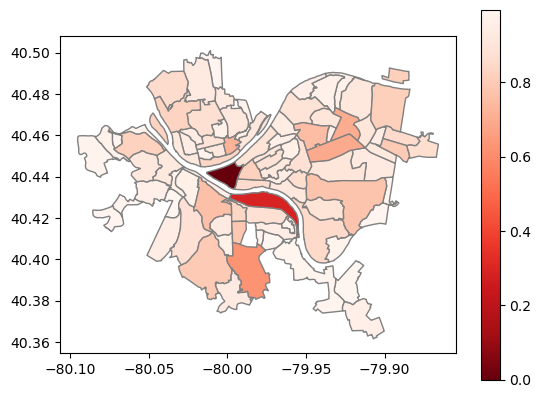

In [10]:
crime_geo = [Point(xy) for xy in zip(crime_df['XCOORD'], crime_df['YCOORD'])]

crime = gpd.GeoDataFrame(crime_df, geometry=crime_geo)
crime.set_crs('EPSG:4326', allow_override=True, inplace=True);

crime = crime.to_crs(neighborhoods.crs)

neighborhood_crime = gpd.sjoin(crime, neighborhoods, how="inner", predicate="within")
crime_count = neighborhood_crime.groupby("hood").size().reset_index(name='crime_count')

neighborhood_crime = neighborhoods.merge(crime_count, on="hood", how="left")
neighborhood_crime["crime_count"] = neighborhood_crime["crime_count"].fillna(0).astype(int)

max_crime = neighborhood_crime['crime_count'].max()
neighborhood_crime['proportion'] = 1 - neighborhood_crime['crime_count'] / max_crime

neighborhood_crime = neighborhood_crime.sort_values(by='proportion', ascending=False)
neighborhood_crime.reset_index(drop=True, inplace=True)

crime_final = neighborhood_crime[['hood', 'crime_count', 'proportion']]

# plot
neighborhood_crime.plot(column='proportion',cmap='Reds_r', edgecolor='gray', legend=True)

In [11]:
crime_final

,hood,crime_count,proportion
0,St. Clair,23,0.995103
1,Ridgemont,24,0.994890
2,New Homestead,36,0.992336
3,Chartiers City,45,0.990419
4,Swisshelm Park,48,0.989781
...,...,...,...
85,East Liberty,1405,0.700873
86,Shadyside,1440,0.693421
87,Carrick,1746,0.628273
88,South Side Flats,3333,0.290398


# Parks

Finally, we score each neighborhood based on the parks dataset. We first convert both neighborhoods onto a flat projection coordinate system so geopandas doesn't get angry when we try to do some shennanigans later.

In [13]:
parks = gpd.read_file("https://data.wprdc.org/dataset/e298e2ae-07c0-4aa4-a2ca-2c8db845b552/resource/ca4ee6a6-3058-487f-9724-2a335b2d79f2/download/parks.geojson")

C:\Users\Yifan Xu\AppData\Local\Temp\ipykernel_45764\1810090066.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  basePlot = neighbor_flat.plot(neighbor_flat, color="white", edgecolor="blue")


<Axes: title={'center': 'Pittsburgh Parks'}>

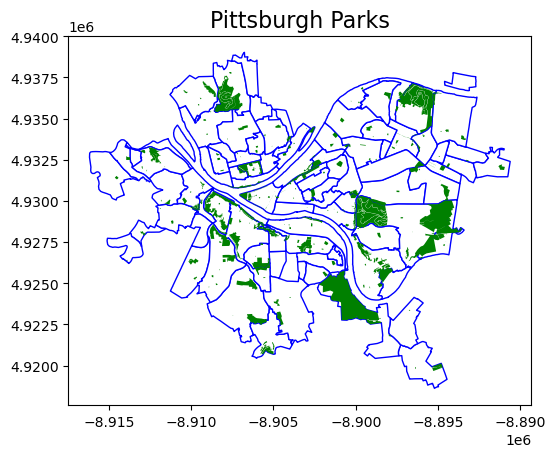

In [14]:
parks_flat = parks.to_crs(crs=3857)
neighborhoods_sm = neighborhoods[['OBJECTID', 'hood', 'acres', 'geometry']].copy()
neighborhoods_sm.rename(columns={'OBJECTID':'id'}, inplace=True)
neighbor_flat = neighborhoods_sm.to_crs(crs=3857)

basePlot = neighbor_flat.plot(neighbor_flat, color="white", edgecolor="blue")
basePlot.set_title("Pittsburgh Parks", fontsize=16)
parks_flat.plot(ax=basePlot, color='green')

Second, we assign each park an "area score", calculated as the square of the area, to represent how the area of the park affect the utility of the park. We then represent each park as a point at the centriod of the park, with the area score as its only attribute.

C:\Users\Yifan Xu\AppData\Local\Temp\ipykernel_45764\3890267562.py:8: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  parks_center.plot(ax=neighbor_flat.plot(neighbor_flat, color="white", edgecolor="blue"), markersize=parks_center['area_score'] / 5, color='green')


<Axes: >

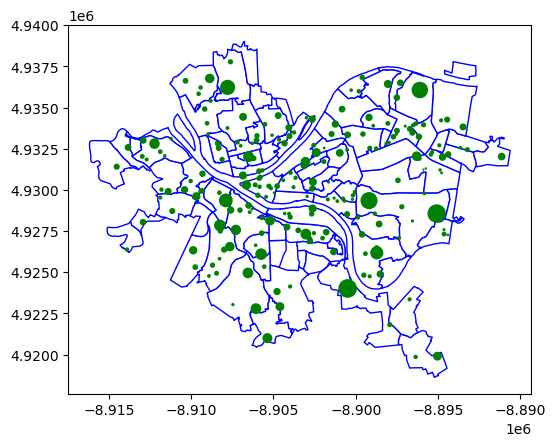

In [16]:
minArea = parks_flat['acreage'].min()

parks_flat['area_score'] = parks_flat.apply(lambda r: math.sqrt(r['acreage'] / minArea), axis=1)
parks_center = gpd.GeoDataFrame(geometry=parks_flat.centroid)
parks_center['area_score'] = parks_flat['area_score']
parks_center['acreage'] = parks_flat['acreage']
parks_center['updatepknm'] = parks_flat['updatepknm']
parks_center.plot(ax=neighbor_flat.plot(neighbor_flat, color="white", edgecolor="blue"), markersize=parks_center['area_score'] / 5, color='green')

Next, we consider each unique pair of neighborhood and park, and consider its distance. For this, we use a cartesian join of the neighborhood and park dataset. Since geopanda's isn't cool with having two geometries in one geoseries, we split the xy point on the park into two seperate float columns and smuggle them into the neighborhoods dataset.

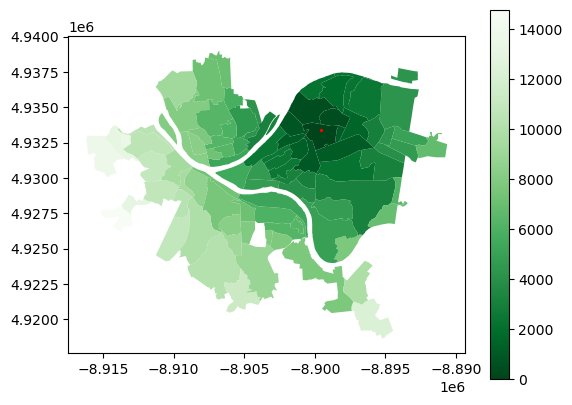

In [18]:
# Create the data to smuggle into neighborhoods dataset
parks_flat['x'] = parks_center.geometry.x
parks_flat['y'] = parks_center.geometry.y
parks_sm = parks_flat[['x', 'y', 'area_score', 'updatepknm', 'acreage']].copy()

# Cartesian join it onto the neighorhoods database
# Since a key column is demanded, we need to trick pandas by having both tables have a column with only one possible value
neighbor_flat['tmp'] = 1
parks_sm['tmp'] = 1

df = neighbor_flat.merge(parks_sm, how='inner', on='tmp')
df.drop(['tmp'], axis=1, inplace=True)

# Now calculate distance by row
df['distance'] = df.apply(lambda r: r['geometry'].distance(Point(r['x'], r['y'])), axis=1)
df.head()

# Check this is working
def plt_map_single_park(data, column, parkname, inverse=False):
    filtered_data = data[data['updatepknm'] == parkname][['id', column]]
    joined = neighbor_flat.merge(filtered_data, how='inner', left_on='id', right_on='id')
    filteredParks = parks_center[parks_center['updatepknm'] == parkname]

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    cmap = 'Greens_r' if inverse else 'Greens'
    basePlt = joined.plot(ax=ax,column=column,cmap=cmap, legend=True)
    filteredParks.plot(ax=ax, color='red', markersize=filteredParks['acreage'])

plt_map_single_park(df, 'distance', 'Friendship Park', True)

We now assign a "distance score" from 0 to 1 to each pair, which represents the the amount of utility the neighborhood gets from the park based on its distance between them (a closer park is more useful than a farther one). The effective "range" of a park is computed as a function of its area, with larger parks being able to attract residents from farther away.

The distance is calculated by the following.

In [20]:
max_radius = 12000
max_acreage = parks_sm['acreage'].max()

def dst_score (acreage, dx):
    ratio = acreage / max_acreage
    radius = ((ratio) ** (1/2)) * max_radius
    value = max(0, (radius - dx) / radius)
    return value * value * value

We can visualize how this a park's area impact impact its score by looking at a few sample parks.

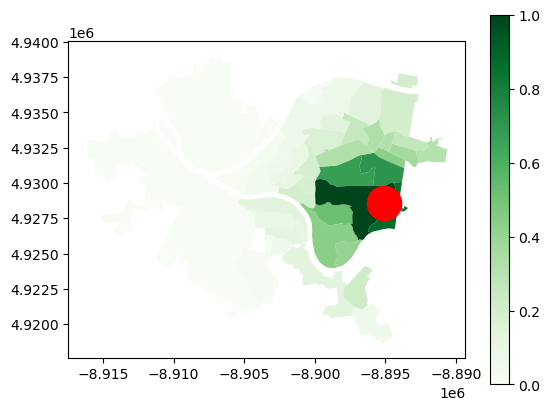

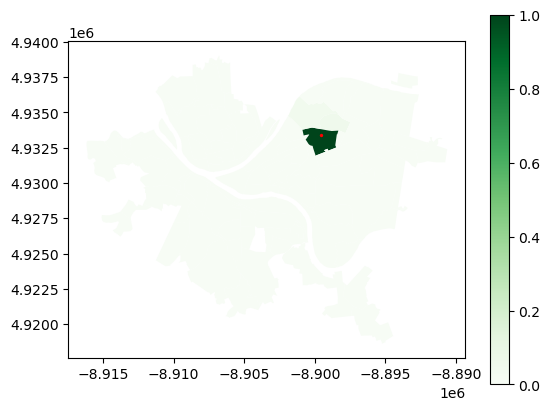

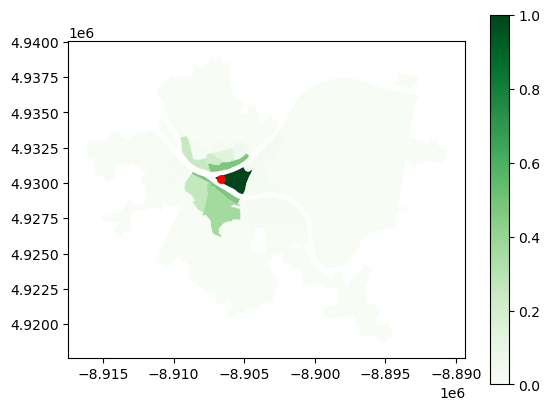

In [22]:
df['dst_score'] = df.apply(lambda r: dst_score(r['acreage'], r['distance']), axis=1)
for p in ['Frick Park', 'Friendship Park', 'Point State Park']:
    plt_map_single_park(df, 'dst_score', p) 

Finally, we tally up all the park score each neighborhood receives, and remap the range to between 0 and 1 to get the final park score.

<Axes: >

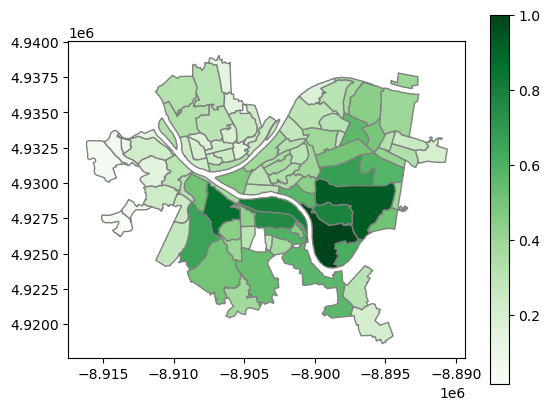

In [101]:
# calculate raw score
df['score_raw'] = df['dst_score'] * df['area_score']

# aggregate score by neighborhood
scores = df.groupby('id').agg({'score_raw': 'sum'})

# merge back into neighnborhoods
park_final = neighbor_flat.merge(scores, how='inner', left_on='id', right_on='id')

# remap to range between 0 - 1
maxScore = park_final['score_raw'].max()
park_final['park_score'] = park_final['score_raw'] / maxScore

# plot
park_final.plot(column='park_score',cmap='Greens', edgecolor='gray', legend=True)

In [73]:
park_final[['hood', 'park_score']].sort_values('park_score', ascending=False).reset_index().drop('index', axis=1).head(10)

,hood,park_score
0,Hazelwood,1.000000
1,Squirrel Hill South,0.929255
2,Mount Washington,0.867979
3,South Side Flats,0.808310
4,Greenfield,0.781646
5,South Side Slopes,0.755675
6,Squirrel Hill North,0.676435
7,Beechview,0.659676
8,Glen Hazel,0.612747
9,Arlington,0.592311


With the way this metric is calculated, since the park dataset do not include parks in neighboring municipalities, neighborhoods on the edge of Pittsburgh are disadvantaged because those parks would have contributed park score to the edge neighborhoods. Despite this, I think this was a fair way to analyze the effect of parks on how nice it is to live in a neighborhood.

For this metric, the winner is convincingly Hazelwood, which has a large amount of small parks and is in close proximity to the largest parks on the map, like Hays Woods, Schenley Park and Frick Park. Squirrel Hill South (which host two of the above parks) is not far behind. 

# Conclusion

We calculate the final score as a sum of the three scores in individual category.

In [77]:
trees_final.dtypes

hood           object
tree_count      int32
tree_score    float64
dtype: object

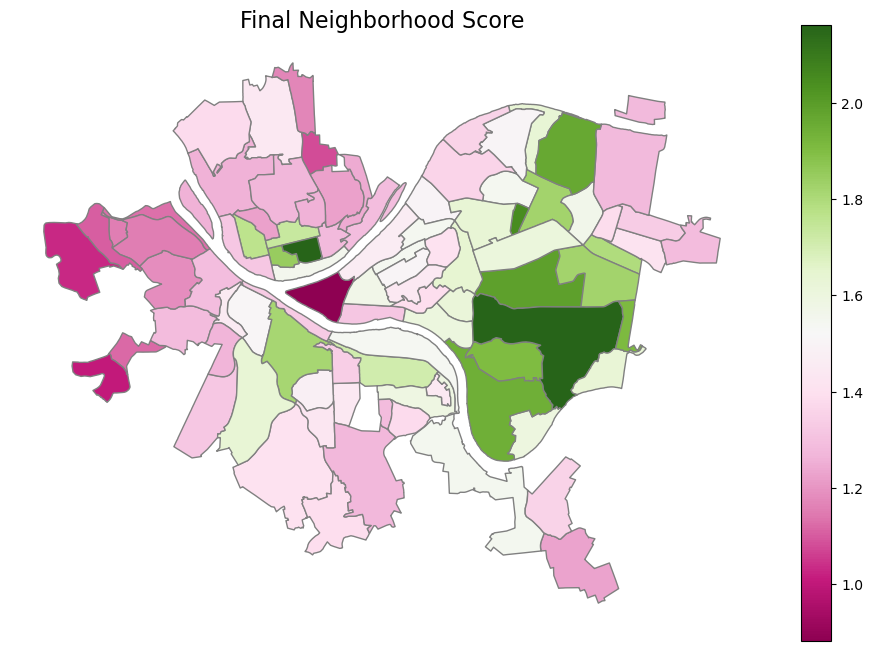

In [150]:
trees_partial = trees


final = park_final.merge(crime_final, how='inner', on='hood').merge(trees_final, how='inner', on='hood')

# all neighborhoods are accounted for
assert len(final) == len(neighborhoods)

# calculate final score
final['score'] = final['tree_score'] + final['crime_score'] + final['park_score']

# plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
final.plot(
    column='score',
    cmap='PiYG',
    ax=ax,
    legend=True,
    edgecolor='gray'
)

ax.set_title("Final Neighborhood Score", fontsize=16)
ax.axis("off")
plt.show()

In [139]:
final_sorted = final.sort_values('score', ascending=False)[['hood', 'tree_score', 'crime_score', 'park_score', 'score']]
final_sorted.head(10)

,hood,tree_score,crime_score,park_score,score
80,Squirrel Hill South,0.456478,0.775601,0.929255,2.161334
45,Allegheny Center,1.000000,0.914201,0.242525,2.156726
41,Friendship,0.821514,0.958484,0.271114,2.051112
1,Squirrel Hill North,0.410291,0.904407,0.676435,1.991134
36,Highland Park,0.605839,0.911433,0.445808,1.963079
60,Hazelwood,0.097432,0.847562,1.000000,1.944994
85,Regent Square,0.530566,0.988290,0.391506,1.910362
27,Greenfield,0.232451,0.887801,0.781646,1.901898
32,Allegheny West,0.642439,0.975942,0.230430,1.848811
11,East Liberty,0.566222,0.700873,0.557700,1.824795


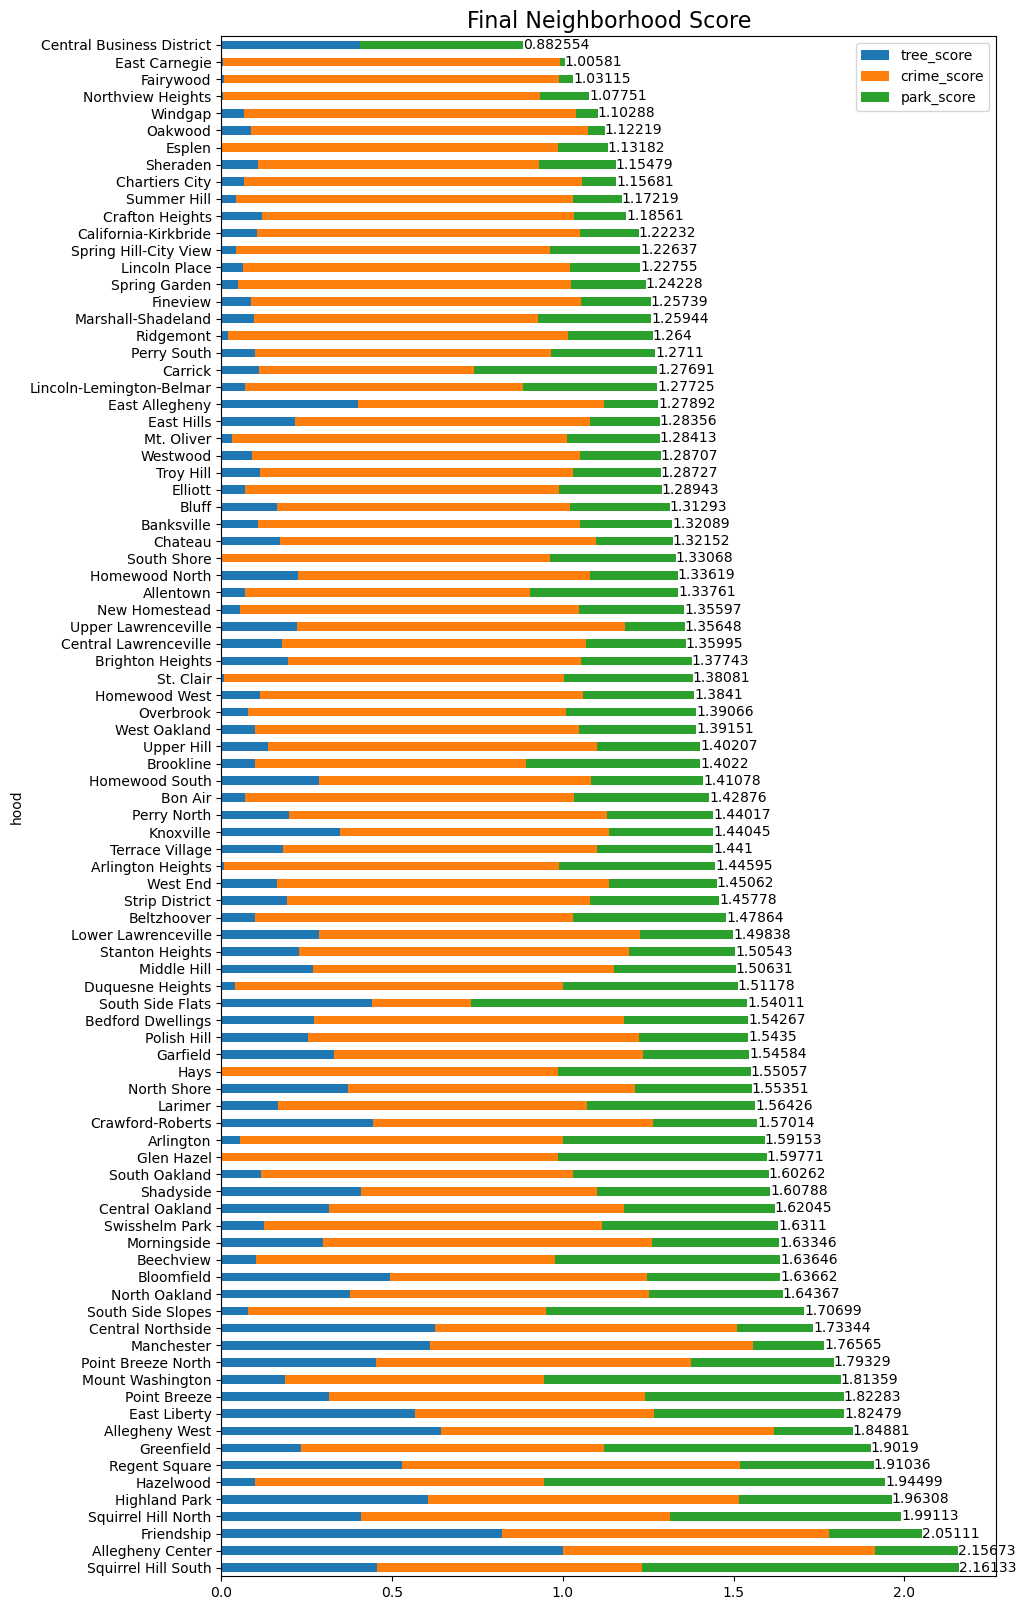

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(10, 20))
final_sorted[['hood', 'tree_score', 'crime_score', 'park_score']].plot.barh(ax=ax, x='hood', stacked=True)

ax.bar_label(ax.containers[2])

ax.set_title("Final Neighborhood Score", fontsize=16)
plt.show()

In conclusion. Squirrel Hill South is the best neighborhood for families, with Allegheny Center very closely behind. Overall, we see a lot of above-average neighborhoods on the eastern side of the city and a small area around Allegheny center, likely due to the number of trees and parks in the area.